In [1]:
# add parent directory to path: enable import from parent dir
import sys
sys.path.append('../')

from environment import SmartBrokerEnv
from agents.a2c import A2C
from networks.a2c_lstm.actor import ActorLSTM
from networks.a2c_lstm.critic import CriticLSTM

import gym
import matplotlib.pyplot as plt
import torch

In [2]:
norm_cols = ['Volume XRP']
cols = ['date'] + ['open', 'high', 'low', 'close', f'Volume XRP']
batch_dur = 60
env = SmartBrokerEnv(
    batch_dur=batch_dur,
    df_info={
        'start_date': '2021-01-01',
        'end_date': '2021-02-01',
        'norm_cols': norm_cols,
        'cols': cols,
    },
    portfolio={

    },
)

/Users/vinay/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/vinay/code/git/smart-broker/notebooks/../environment.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['rolling_price'] = self.df[self.price_typ].rolling(self.roll_period).sum()
/Users/vinay/miniforge3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [3]:
actor_model = ActorLSTM(
    state_dim=batch_dur*3+3,
    action_dim=3,
)
critic_model = CriticLSTM(state_dim=batch_dur*3+3)
a2c = A2C(
    env=env, 
    actor=actor_model,
    critic=critic_model,
    n_actns=3,
    actor_optmz=torch.optim.Adam(actor_model.parameters(), lr=0.001),
    critic_optmz=torch.optim.Adam(critic_model.parameters(), lr=0.001),
    hyprprms={
        'gamma': 0.9995,
    },
    log_freq=25,
    p_net_type='lstm',
    c_net_type='lstm',
)

In [4]:
a2c.run(5000)


Ep: 0 | L: 0.945 | R: 52.63 | R.Avg.R: 52.63 | P: 1.88 | R.Avg P: 1 | B: 50.04 | R.Avg B: 50 | R.N_Units: 225
Ep: 25 | L: 1.006 | R: 53.59 | R.Avg.R: 53.23 | P: 3.36 | R.Avg P: 2 | B: 44.47 | R.Avg B: 48 | R.N_Units: 235
Ep: 50 | L: 0.996 | R: 54.77 | R.Avg.R: 53.62 | P: 4.68 | R.Avg P: 3 | B: 51.19 | R.Avg B: 47 | R.N_Units: 242
Ep: 75 | L: 0.998 | R: 53.38 | R.Avg.R: 53.83 | P: 3.23 | R.Avg P: 3 | B: 29.73 | R.Avg B: 41 | R.N_Units: 268
Ep: 100 | L: 0.998 | R: 53.26 | R.Avg.R: 53.79 | P: 3.1 | R.Avg P: 3 | B: 32.43 | R.Avg B: 36 | R.N_Units: 292
Ep: 125 | L: 0.998 | R: 53.39 | R.Avg.R: 53.43 | P: 2.87 | R.Avg P: 3 | B: 39.2 | R.Avg B: 36 | R.N_Units: 290
Ep: 150 | L: 0.998 | R: 54.09 | R.Avg.R: 53.52 | P: 3.98 | R.Avg P: 3 | B: 45.63 | R.Avg B: 39 | R.N_Units: 274
Ep: 175 | L: 0.998 | R: 54.4 | R.Avg.R: 53.09 | P: 4.25 | R.Avg P: 2 | B: 52.92 | R.Avg B: 44 | R.N_Units: 254
Ep: 200 | L: 0.998 | R: 54.03 | R.Avg.R: 53.69 | P: 4.19 | R.Avg P: 2 | B: 47.66 | R.Avg B: 46 | R.N_Units: 245

KeyboardInterrupt: 

## Visualizations

### Traning 

Text(0.5, 1.0, 'Rolling avg balance per episode')

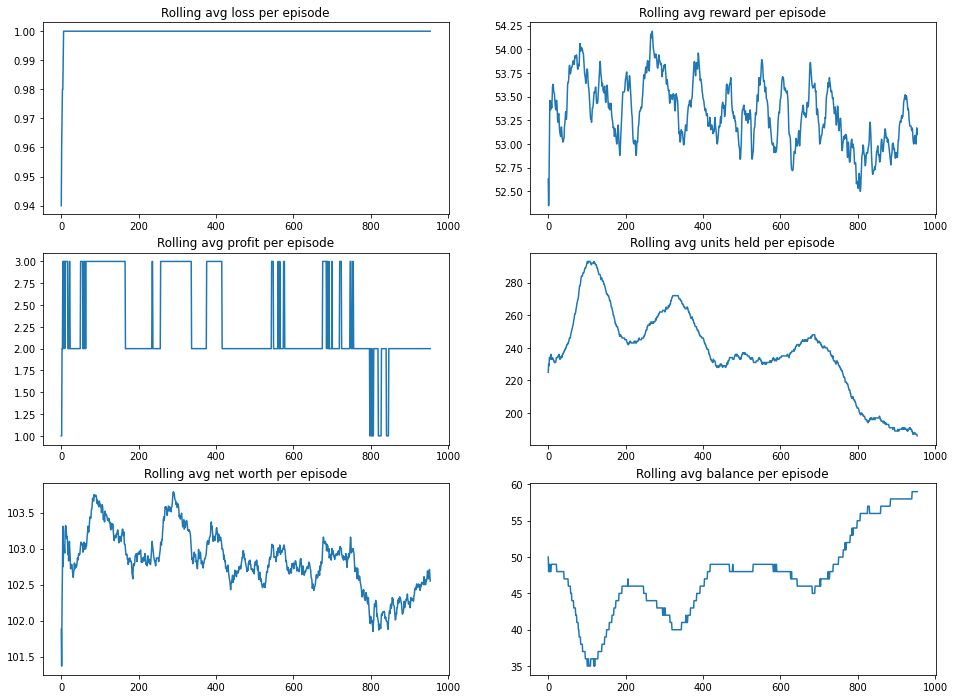

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
r_avg_rewards = []
r_avg_profits = []
r_avg_bal = []
r_avg_units_held = []
r_avg_loss = []
r_avg_net_worth = []
count = 0

for _, log in a2c.logs.items():
    r_avg_rewards.append(log['r_avg_reward'])
    r_avg_profits.append(log['r_avg_profit'])
    r_avg_bal.append(log['r_avg_bal'])
    r_avg_units_held.append(log['r_avg_units_held'])
    r_avg_loss.append(log['r_avg_loss'])
    r_avg_net_worth.append(log['r_avg_net_worth'])
    count += 1

ax[0][0].plot(range(count), r_avg_loss)
ax[0][0].set_title('Rolling avg loss per episode')

ax[0][1].plot(range(count), r_avg_rewards)
ax[0][1].set_title('Rolling avg reward per episode')

ax[1][0].plot(range(count), r_avg_profits)
ax[1][0].set_title('Rolling avg profit per episode')

ax[1][1].plot(range(count), r_avg_units_held)
ax[1][1].set_title('Rolling avg units held per episode')

ax[2][0].plot(range(count), r_avg_net_worth)
ax[2][0].set_title('Rolling avg net worth per episode')

ax[2][1].plot(range(count), r_avg_bal)
ax[2][1].set_title('Rolling avg balance per episode')

In [ ]:
# import pickle
# with open("../pickles/a2c_logs.pickle","wb") as f:
#     pickle.dump(temp, f, pickle.HIGHEST_PROTOCOL)